#MCMC integration test

Here, we'll test performance of the nGP model on sample data

In [1]:
import NGPtools
using Distributions
using PyPlot
plt.style[:use]("ggplot")

srand(12345) # set random seed

INFO: Loading help data...


## Load Data

In [2]:
data = readcsv("data/blocks_sampled.csv")
tobs = data[:, 1]
y = data[:, 2]'
Nt = length(y)

128

## Define some useful variables

In [3]:
δ = diff([tobs, 1.1])
Np, Nm, Nr = 1, 3, 3
dims = Np, Nm, Nr

(1,3,3)

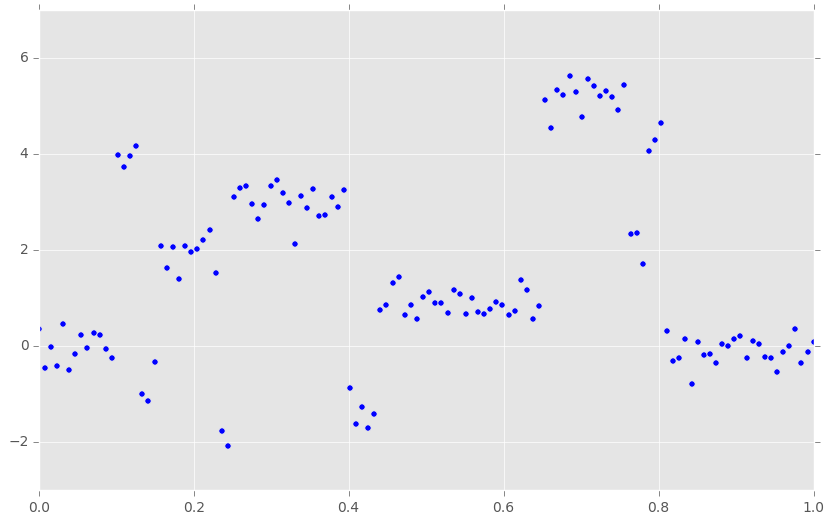

(0,1)

In [4]:
figure(figsize=(10, 6))
scatter(tobs, y);
xlim(0, 1)

## Pick priors and initial parameter values

In [5]:
σU = 1e3
σA = 5.
σϵ = 1.
σμ = 4.
σα = 4.
a, b = 1., 1.

(1.0,1.0)

## Algorithm

The algorithm is as follows:

1. Given the various $\sigma^2$ parameters, perform an exact draw from the posterior for the state vector 
    $(U, DU, A)$.
1. Given the state vector, draw
    $$
    \sigma^2_\epsilon \sim \text{inv-Ga}\left( 
    a + \frac{N_t}{2},
    b + \frac{1}{2} \sum_t (y_t - U(t))^2
    \right)
    $$
1. Sample $\sigma^2_U$ and $\sigma^2_A$:

    1. Draw a sample of the state vector, $(U^*, DU^*, A^*)$, from the approximate model.
    1. Conditioned on this approximate state vector, sample proposed variance parameters as
        $$\begin{align}
        \sigma^2 &\sim \text{inv-Ga}\left(a + \frac{N_t}{2}, b + \frac{1}{2} R^2 \right) \\
        R^2_U &= \sum_j \frac{\left[DU^*(t_{j+1}) - DU^*(t_j) - A^*(t_j)\delta_j\right]^2}{\delta_j} \\
        R^2_A &= \sum_j \left[\frac{(A^*(t_{j+1}) - A^*(t_j))^2}{\delta_j}\right]
        \end{align}$$
    1. Accept these proposals with probability $\mathrm{min}(\pi, 1)$ with
        $$
        \pi \equiv \prod_j \frac{\mathcal{N}(\theta_{j + 1} - G_j\theta_j|0, W^*_j)}
        {\mathcal{N}(\theta_{j + 1} - G_j\theta_j|0, W_j)}
        \frac{\mathcal{N}(\tilde{H}^\top (\theta^*_{j + 1} - \tilde{G}_j\theta^*_j)|0, \tilde{W}_j)}
        {\mathcal{N}(\tilde{H}^\top (\theta^*_{j + 1} - \tilde{G}_j\theta^*_j)|0, \tilde{W}^*_j)}
        $$
        (Think of this like $\frac{P(x')}{P(x)}\frac{g(x)}{g(x')}$, with $P$ the posterior and $g$ the proposal 
        distribution, and recall that what we are proposing is $\sigma^2|\theta^*$).

## Useful functions

In [6]:
function draw_state(σϵ, σU, σA, approx=false)
    return NGPtools.sample(y, 1, dims, δ, σϵ, σU, σA, σμ, σα, approx)[:, :, 1]
end

draw_state (generic function with 2 methods)

In [7]:
function draw_σϵ(U)
    a_eff = a + (Nt / 2)
    b_eff = b + 0.5 * sum((y - U).^2)
    return rand(InverseGamma(a_eff, b_eff))
end

draw_σϵ (generic function with 1 method)

In [8]:
function calc_acceptance_prob(θ, θstar, G, Gtilde, W, Wstar, Wtilde, Wtilde_star, Htilde)
    Nt = size(θ)[end]
    v = similar(θ)
    v_star = Array(Float64, size(Htilde)[end], Nt)
    
    for t in 1:(Nt - 1)
        v[:, t] = θ[:, t + 1] - G[:, :, t] * θ[:, t]
        v_star[:, t] = Htilde' * (θstar[:, t + 1] - Gtilde[:, :, t] * θstar[:, t])
    end
    
    pi = 0
    for t in 1:Nt
        pi += logpdf(MvNormal(Wstar[:, :, t]), v[:, t])
        pi -= logpdf(MvNormal(W[:, :, t]), v[:, t])
        pi += logpdf(MvNormal(Wtilde[:, :, t]), v_star[:, t])
        pi -= logpdf(MvNormal(Wtilde_star[:, :, t]), v_star[:, t])
    end
    
    return min(exp(pi), 1)
end

calc_acceptance_prob (generic function with 1 method)

In [9]:
function draw_sigs(θ, σϵ, σU, σA)
    Nt = size(θ)[end]
    
    # draw state from approximate model
    θstar = draw_state(σϵ, σU, σA, true)
    
    Ustar = θstar[1, :][:]
    DUstar = θstar[2, :][:]
    Astar = θstar[3, :][:]
    
    # calculate sufficient statistics
    d = δ[1:(end - 1)]
    R2U = sum( (diff(DUstar) - Astar[1:(end - 1)] .* d).^2 ./ d )
    R2A = sum(diff(Astar).^2 ./ d)
    
    # draw proposals
    a_eff = a + (Nt / 2)
    σUstar = sqrt(rand(InverseGamma(a_eff, b + R2U/2)))
    σAstar = sqrt(rand(InverseGamma(a_eff, b + R2A/2)))
    
    assert(σUstar > 0)
    assert(σAstar > 0)
    
    _, _, G, H, W, _, _ = NGPtools.assemble_matrices(dims, δ, σϵ, σU, σA, σμ, σα)
    _, _, Gtilde, Htilde, Wtilde, _, _ = NGPtools.assemble_matrices(dims, δ, σϵ, σU, σA, σμ, σα, true)
    _, _, _, _, Wstar, _, _ = NGPtools.assemble_matrices(dims, δ, σϵ, σUstar, σAstar, σμ, σα)
    _, _, _, _, Wtilde_star, _, _ = NGPtools.assemble_matrices(dims, δ, σϵ, σUstar, σAstar, σμ, σα, true)
    
    # get acceptance probability
    acc_prob = calc_acceptance_prob(θ, θstar, G, Gtilde, W, Wstar, Wtilde, Wtilde_star, Htilde)
    
    if rand() < acc_prob
        return σUstar, σAstar
    else
        return σU, σA
    end
end

draw_sigs (generic function with 1 method)

In [10]:
function fit_data(Niter, burnin, σϵ, σU, σA)
    # initialize
    th = Array(Float64, Nm, Nt, Niter + burnin)
    sig = Array(Float64, 3, Niter + burnin)

    # draw samples
    for idx in 1:(Niter + burnin)
        θ = draw_state(σϵ, σU, σA)
        σϵ = draw_σϵ(θ[1, :])
        σU, σA = draw_sigs(θ, σϵ, σU, σA)

        th[:, :, idx] = θ
        sig[:, idx] = [σϵ, σU, σA]
    end
    
    return th[:, :, (burnin + 1):end], sig[:, (burnin + 1):end]
end

fit_data (generic function with 1 method)

In [11]:
Niter = 1000
burn = 500

@time th, sig = fit_data(Niter, burn, σϵ, σU, σA)

sig[:, end]

elapsed time: 23.762893759 seconds (10054319944 bytes allocated, 36.71% gc time)


3-element Array{Float64,1}:
   1.23021
 218.463  
   1.58278

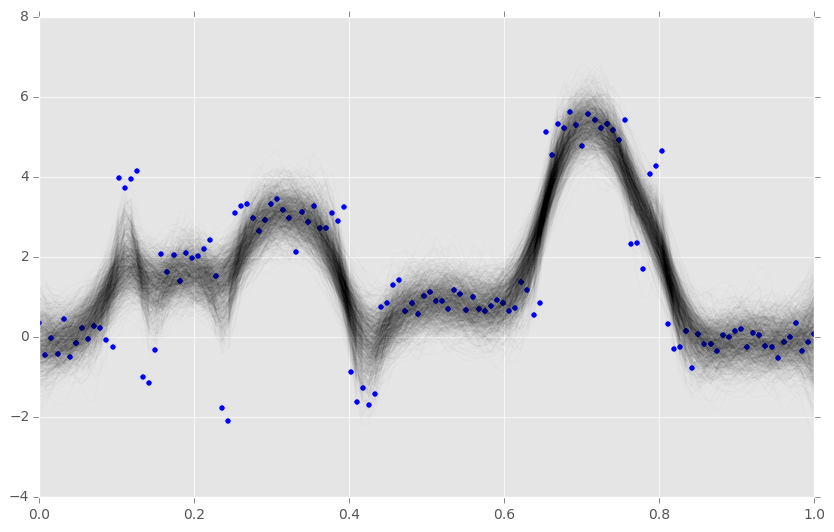

(0,1)

In [12]:
figure(figsize=(10, 6))
trans = 15. / size(th, 3)

plot(tobs, squeeze(th[1, :, :], 1), color="black", alpha=trans)
scatter(tobs, y)
xlim(0, 1)

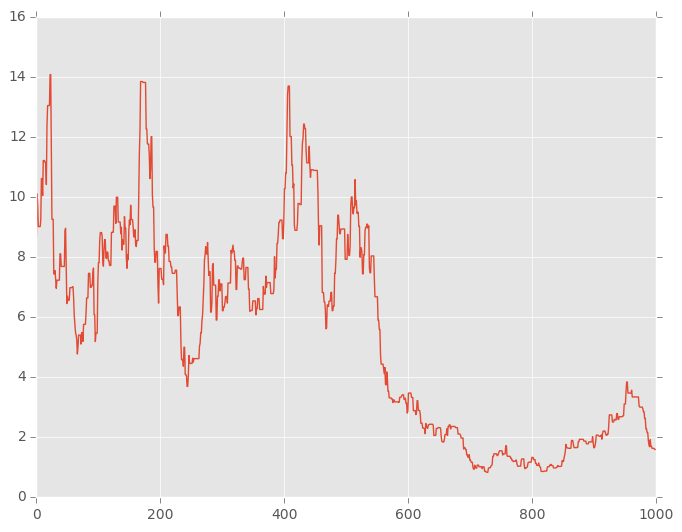

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x12285ce10>

In [13]:
plot(sig[3, :]')